### Instalar dependencias

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=905b2e71a4686cc56bb302a614c928e90ddefeea7a9abc34b35c31bd64818eef
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you ha

### Configuración del entorno

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from random import shuffle, choices
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import os
import re
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import torch
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
path = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_images')

In [ ]:
def label_func(fname):
    fname = str(fname)
    match = re.search(r'_(\d)_\.png$', fname)
    return int(match.group(1)) if match else 0

In [ ]:
from fastai.vision.all import *
import torch

In [ ]:
from sklearn.metrics import f1_score, recall_score

In [ ]:
learn = load_learner('/content/drive/MyDrive/VIU/TFM/modelos/sesgo_evidente/modelo_con_sesgo_evidente_v3.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


#### Obtener predicción

In [ ]:
img_name = "7_test_1_.png"
img_name = "47_test_1_.png"

In [ ]:
# img_name = "80_test_1_.png" # tubos
img_name = "101_test_1_.png" # pulmon a la mitad
# img_name = "986_test_1_.png"

In [ ]:
img_route = path / img_name
pred_class, _, probs = learn.predict(img_route)
pred = int(pred_class)
print("pred", pred)

dl = learn.dls.test_dl([img_route])   # crea un dataloader de prueba
input_tensor = dl.one_batch()[0].to(device)

target_class = ClassifierOutputTarget(pred)
classes = [target_class]

pred 1


In [ ]:
def show_tensor_image(tensor, idx=0):
    """
    Muestra un tensor de imagen normalizado [B,C,H,W] correctamente.
    """
    img = tensor[idx].detach().cpu()  # [C,H,W]

    # Desnormalizar usando los mismos mean/std de ImageNet
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img = img * std + mean  # desnormalizar

    img = img.permute(1,2,0).clamp(0,1)  # [H,W,C] y limitar a [0,1]

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

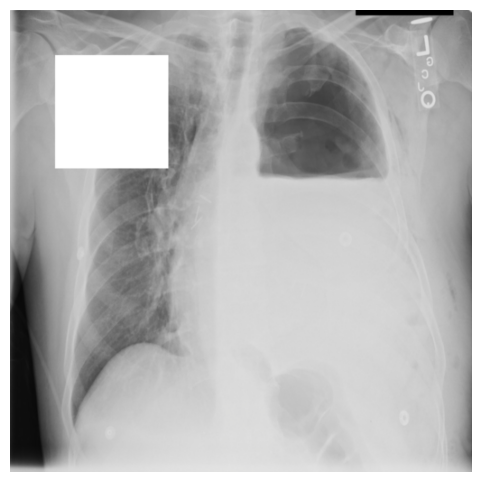

In [ ]:
show_tensor_image(input_tensor)

#### Obtener el modelo y últimas capas convolucionales

In [ ]:
learn.model.to(device)
model = learn.model
model.eval()
# last_conv_layer = model[0][0].denseblock4.denselayer16.conv2
# last_conv_layer = model[0][0]
last_conv_layer = model[0][0].denseblock4 # Este bloque contiene todas las capas finales convolucionales
model = learn.model
layers = [last_conv_layer]

#### Mostramos la imagen y la máscara de test

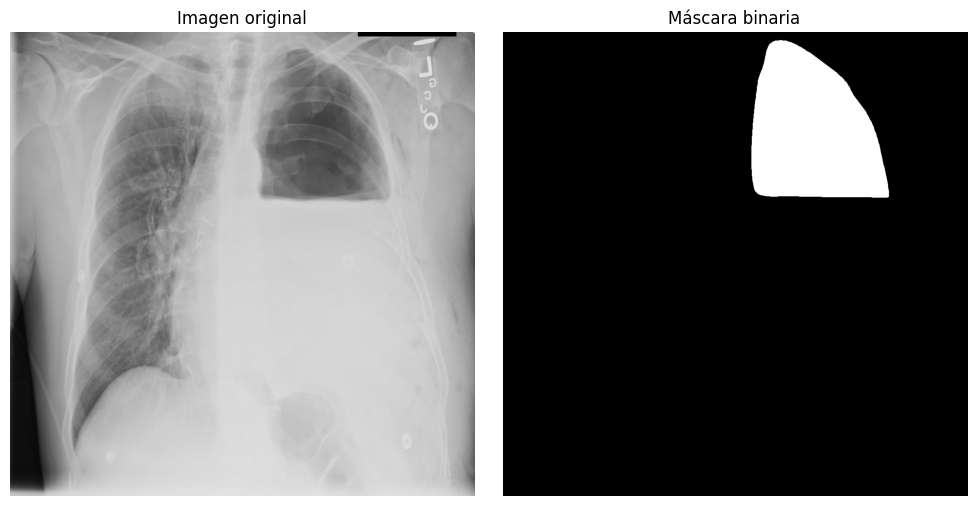

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen original y la máscara
original_img = Image.open(img_route).convert("RGB")
mask_path = path.parent / 'png_masks' / img_name
mask_img = Image.open(mask_path).convert("L")

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
axes[0].imshow(original_img)
axes[0].set_title("Imagen original")
axes[0].axis('off')

# Máscara binaria
axes[1].imshow(mask_img, cmap='gray')
axes[1].set_title("Máscara binaria")
axes[1].axis('off')

plt.tight_layout()
plt.show()

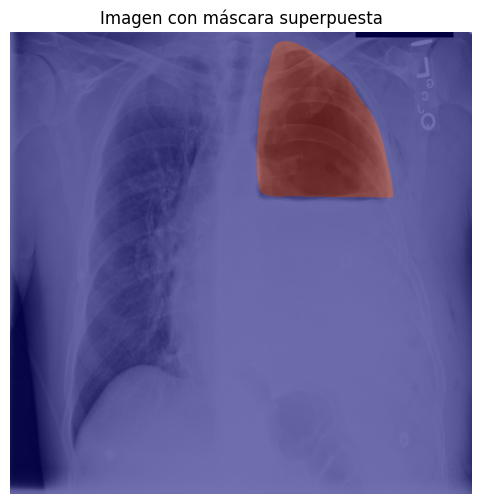

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Cargar imagen RGB y máscara en escala de grises
original_img = Image.open(img_route).convert("RGB")
mask_path = path.parent / 'png_masks' / img_name
mask_img = Image.open(mask_path).convert("L")  # blanco y negro

# Convertir a arrays para asegurar alineación
original_np = np.array(original_img)
mask_np = np.array(mask_img)

# Crear superposición
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(original_np)
ax.imshow(mask_np, cmap='jet', alpha=0.5)  # superposición con color y transparencia
ax.set_title("Imagen con máscara superpuesta")
ax.axis('off')
plt.show()

#### Comparación de CAM con Ground Truth

In [ ]:
def tensor_to_pil(tensor, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    """
    Convierte un tensor [B,C,H,W] o [C,H,W] normalizado a una imagen PIL.
    """
    if tensor.ndim == 4:
        tensor = tensor[0]  # tomar el primer batch
    tensor = tensor.detach().cpu()
    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)
    img = tensor * std + mean
    img = img.clamp(0,1).permute(1,2,0)  # [H,W,C]
    return Image.fromarray((img.numpy()*255).astype("uint8"))

In [ ]:
def visualize_all_cam_comparison(img_name):

    # Cargar imagen
    img_route = path / img_name
    image = Image.open(img_route).convert("RGB")
    mask_path = path.parent / 'png_masks' / img_name
    mask_img = Image.open(mask_path).convert("L")

    # Obtener clase objetivo
    pred_class, _, probs = learn.predict(img_route)
    pred = int(pred_class)
    print("predicción:", pred)
    target_class = ClassifierOutputTarget(pred)
    classes = [target_class]

    # Preprocesar
    dl = learn.dls.test_dl([img_route])   # crea un dataloader de prueba
    input_tensor = dl.one_batch()[0].to(device)
    image = tensor_to_pil(input_tensor)

    # --- GradCAM ---
    gradcam = GradCAM(model=model, target_layers=layers)
    gradcam_map = gradcam(input_tensor=input_tensor, targets=classes).squeeze()
    gradcam_map = (gradcam_map >= 0).astype(float) * gradcam_map

    gradcampp = GradCAMPlusPlus(model=model, target_layers=layers)
    gradcampp_map = gradcampp(input_tensor=input_tensor, targets=classes).squeeze()
    gradcampp_map = (gradcampp_map >= 0).astype(float) * gradcampp_map

    eigencam = EigenCAM(model=model, target_layers=layers)
    eigencam_map = eigencam(input_tensor=input_tensor, targets=classes).squeeze()
    eigencam_map = (eigencam_map >= 0).astype(float) * eigencam_map

    xgradcam = XGradCAM(model=model, target_layers=layers)
    xgradcam_map = xgradcam(input_tensor=input_tensor, targets=classes).squeeze()
    xgradcam_map = (xgradcam_map >= 0).astype(float) * xgradcam_map

    scorecam = ScoreCAM(model=model, target_layers=layers)
    scorecam_map = scorecam(input_tensor=input_tensor, targets=classes).squeeze()
    scorecam_map = (scorecam_map >= 0).astype(float) * scorecam_map

    # Mostrar
    fig, axs = plt.subplots(2, 3, figsize=(9, 7))

    axs[0][0].imshow(image.resize((1024, 1024), Image.BILINEAR))
    axs[0][0].imshow(mask_img, cmap='jet', alpha=0.5)
    axs[0][0].set_title("Imagen original")
    axs[0][0].axis('off')

    axs[0][1].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[0][1].imshow(gradcam_map, cmap='jet', alpha=0.5)
    axs[0][1].set_title(f"GradCAM")
    axs[0][1].axis('off')

    axs[0][2].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[0][2].imshow(gradcampp_map, cmap='jet', alpha=0.5)
    axs[0][2].set_title(f"GradCAM++")
    axs[0][2].axis('off')

    axs[1][0].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1][0].imshow(eigencam_map, cmap='jet', alpha=0.5)
    axs[1][0].set_title(f"EigenCAM")
    axs[1][0].axis('off')

    axs[1][1].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1][1].imshow(xgradcam_map, cmap='jet', alpha=0.5)
    axs[1][1].set_title(f"XGradCAM")
    axs[1][1].axis('off')

    axs[1][2].imshow(image.resize((512, 512), Image.BILINEAR))
    axs[1][2].imshow(scorecam_map, cmap='jet', alpha=0.5)
    axs[1][2].set_title(f"ScoreCAM")
    axs[1][2].axis('off')

    plt.tight_layout()
    plt.show()

100%|██████████| 64/64 [25:50<00:00, 24.22s/it]


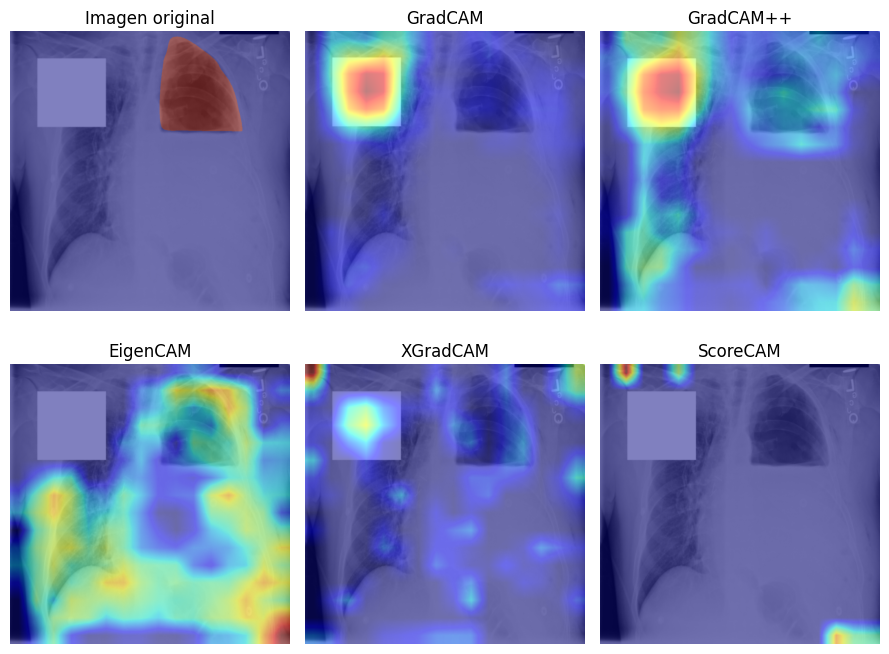

In [ ]:
visualize_all_cam_comparison("101_test_1_.png")

100%|██████████| 64/64 [18:40<00:00, 17.50s/it]


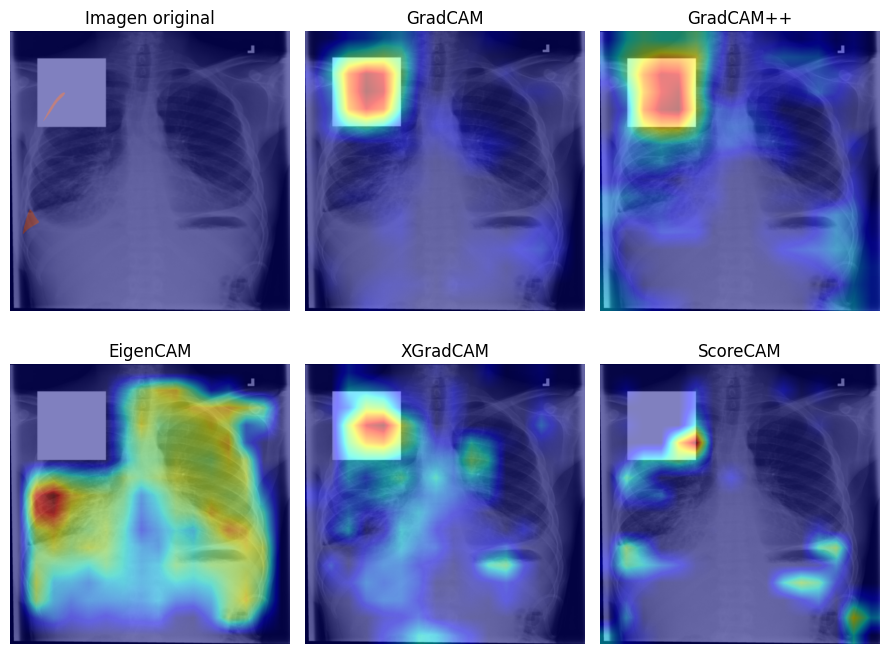

In [ ]:
visualize_all_cam_comparison("47_test_1_.png")

100%|██████████| 64/64 [19:24<00:00, 18.19s/it]


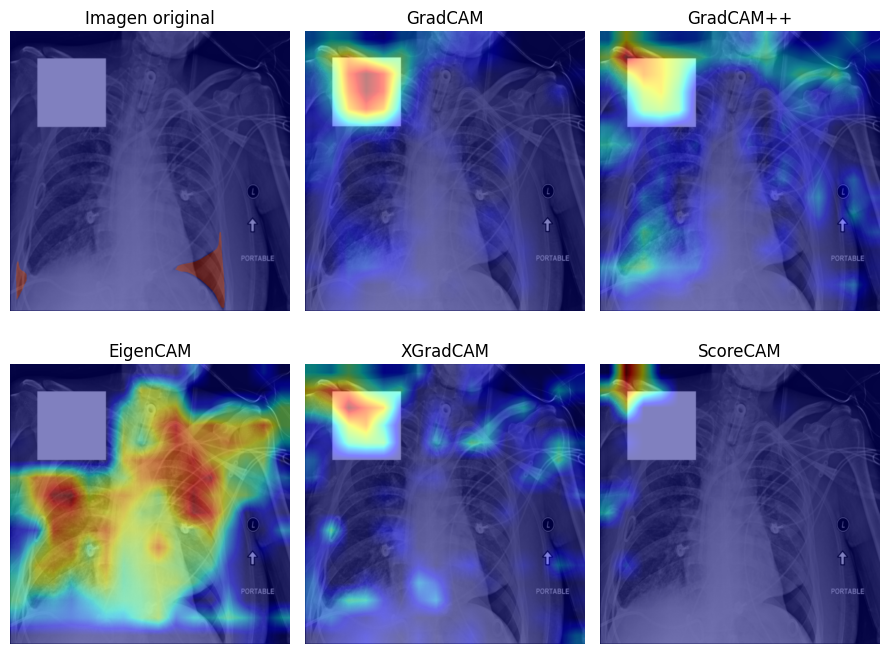

In [ ]:
visualize_all_cam_comparison("7_test_1_.png")

Una sana

predicción: 0


100%|██████████| 64/64 [23:27<00:00, 21.99s/it]


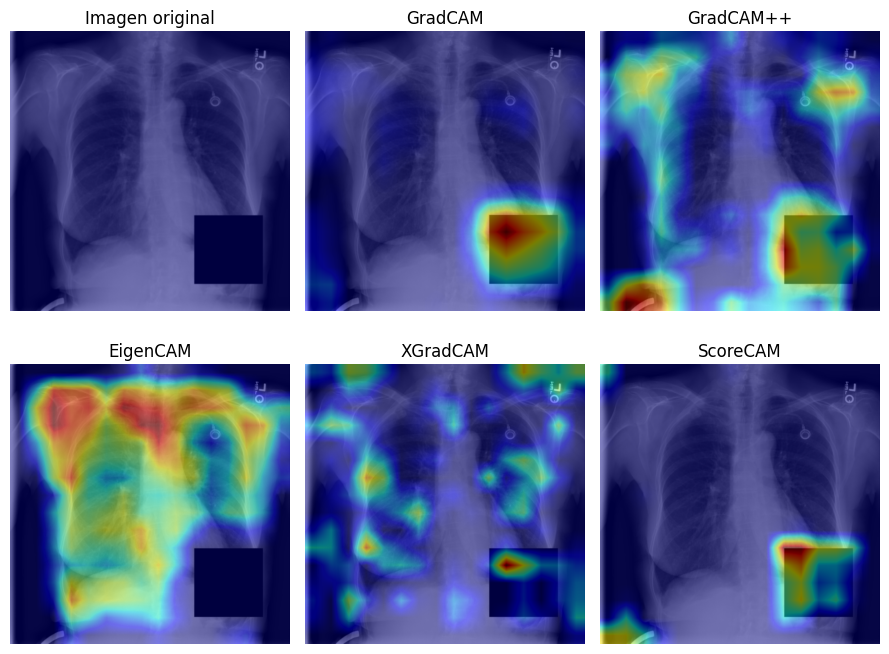

In [ ]:
visualize_all_cam_comparison("26_test_0_.png")

predicción: 0


100%|██████████| 64/64 [25:55<00:00, 24.31s/it]


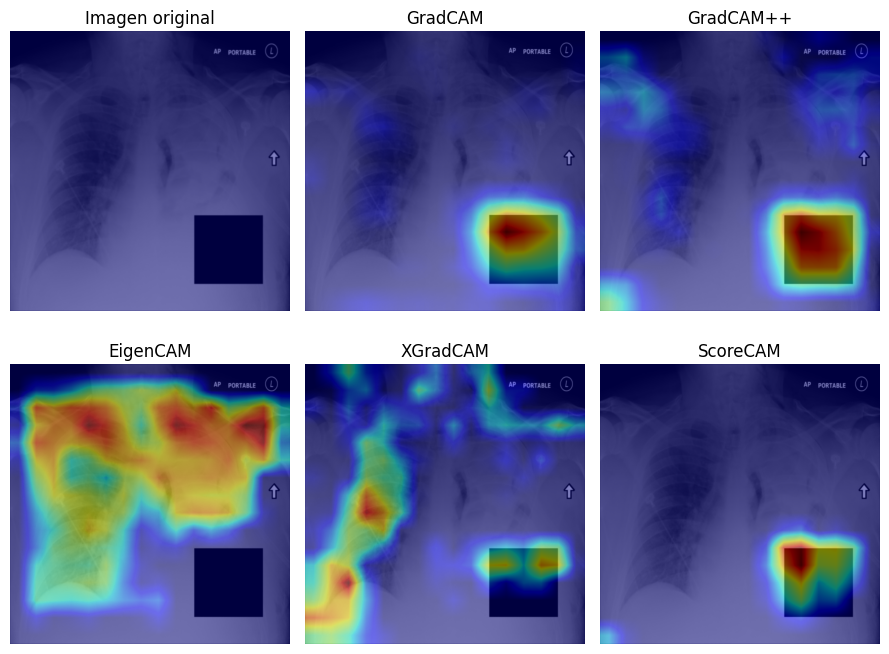

In [ ]:
visualize_all_cam_comparison("39_test_0_.png")

v2

predicción: 0


100%|██████████| 64/64 [24:59<00:00, 23.43s/it]


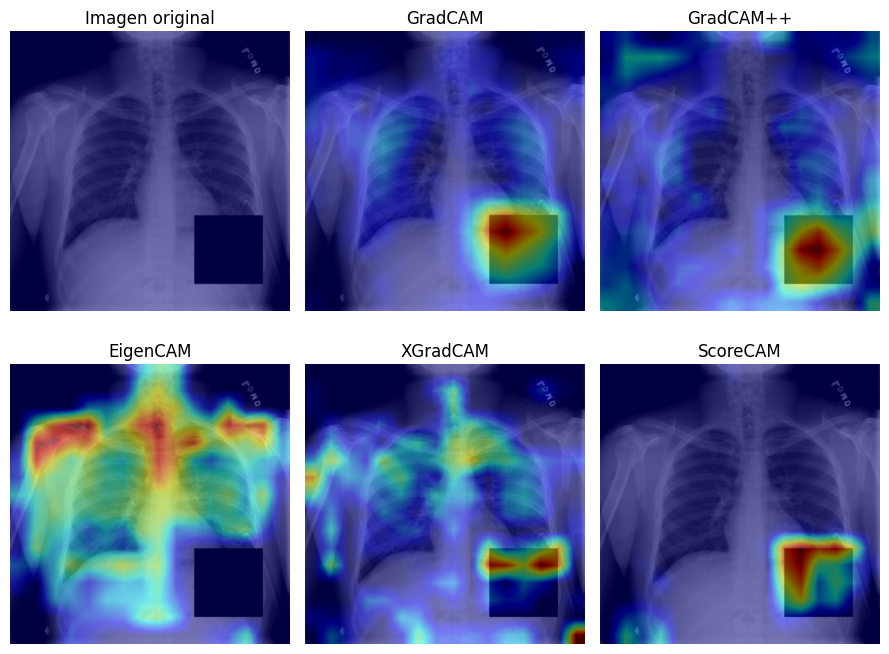

In [ ]:
visualize_all_cam_comparison("79_test_0_.png")

predicción: 0


100%|██████████| 64/64 [16:33<00:00, 15.53s/it]


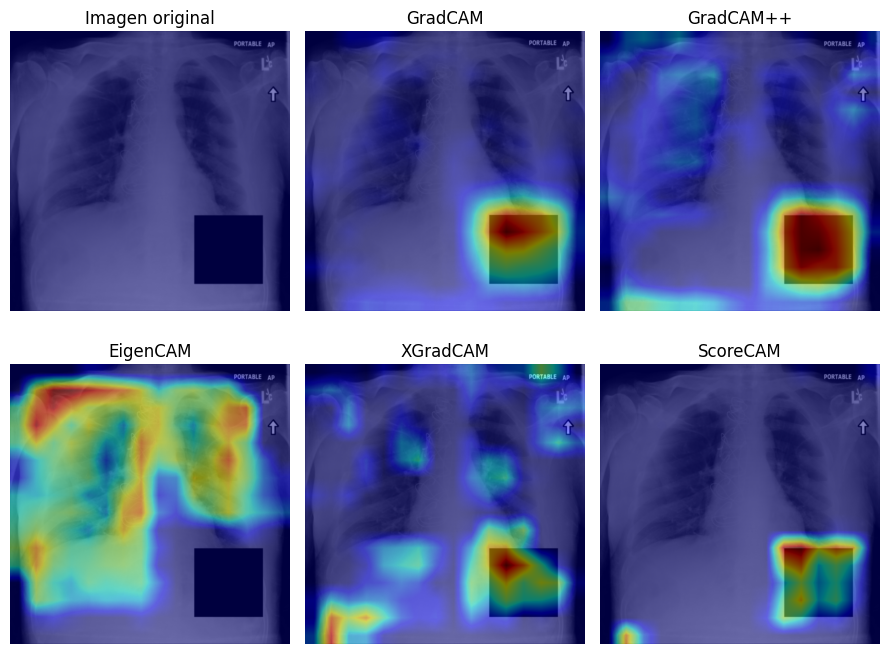

In [ ]:
visualize_all_cam_comparison("88_test_0_.png")

### Grad-CAM

(-0.5, 511.5, 511.5, -0.5)

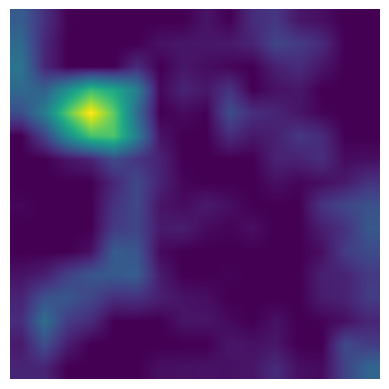

In [ ]:
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)
plt.imshow(heatmap[0])
plt.axis('off')

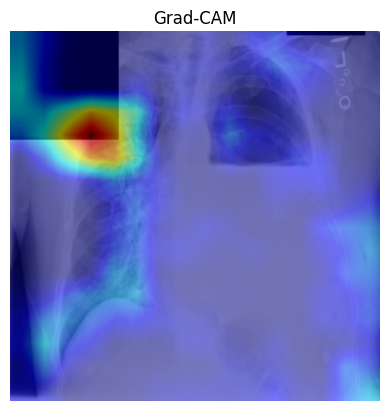

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
#img = Image.open(img_route).convert('RGB')
#img = img.resize((heatmap[0].shape[1], heatmap[0].shape[0]))  # asegurar mismo tamaño que el heatmap
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()

(-0.5, 511.5, 511.5, -0.5)

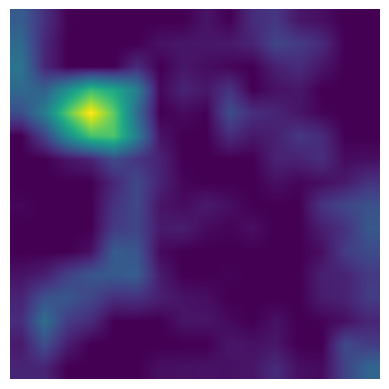

In [ ]:
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)
plt.imshow(heatmap[0])
plt.axis('off')

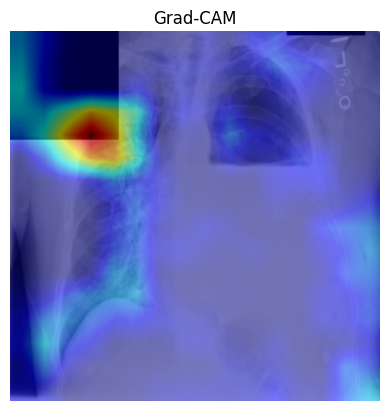

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
#img = Image.open(img_route).convert('RGB')
#img = img.resize((heatmap[0].shape[1], heatmap[0].shape[0]))  # asegurar mismo tamaño que el heatmap
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()

#### Testing métricas

Definimos funciones para calcular IoU y Dice

In [ ]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def compute_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2 * intersection / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) != 0 else 0

Ponemos el heatmap en el rango 0, 1

In [ ]:
heatmap_np = heatmap[0]
heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min())

In [ ]:
# Carga y convierte a binario
mask_np = np.array(mask_img)
# Máscara Ground Truth
gt_mask = (mask_np > 0).astype(np.uint8)

Redimensionamos el heatmap al tamaño de la máscara

In [ ]:
from skimage.transform import resize
heatmap_resized = resize(heatmap_np, gt_mask.shape, preserve_range=True)

Calculamos IoU y Dice para 50 thresholds

In [ ]:
thresholds = np.linspace(0, 1, 50)
ious, dices = [], []

for t in thresholds:
    binary_heatmap = (heatmap_resized >= t).astype(np.uint8)
    iou = compute_iou(binary_heatmap, gt_mask)
    dice = compute_dice(binary_heatmap, gt_mask)
    ious.append(iou)
    dices.append(dice)

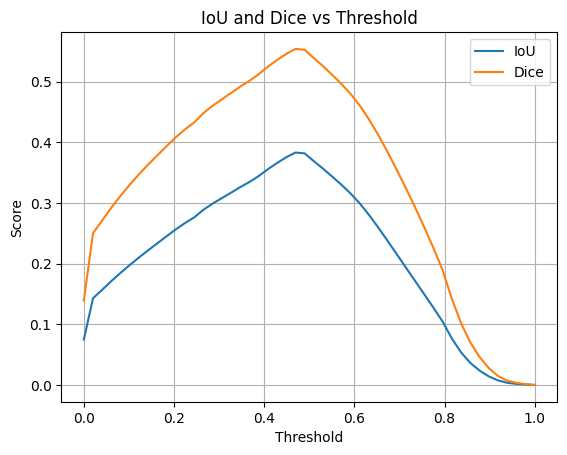

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, ious, label="IoU")
plt.plot(thresholds, dices, label="Dice")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("IoU and Dice vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

Identificamos el mejor threshold y se obtienen los valores correspondientes

In [ ]:
best_idx = np.argmax(dices)
print(f"Mejor threshold: {thresholds[best_idx]:.2f}")
print(f"IoU: {ious[best_idx]:.4f}, Dice: {dices[best_idx]:.4f}")

Mejor threshold: 0.47
IoU: 0.3832, Dice: 0.5541


Se visualiza la máscara generada por el método XAI utilizando el threshold óptimo, con el fin de verificar visualmente su solapamiento con el ground truth.

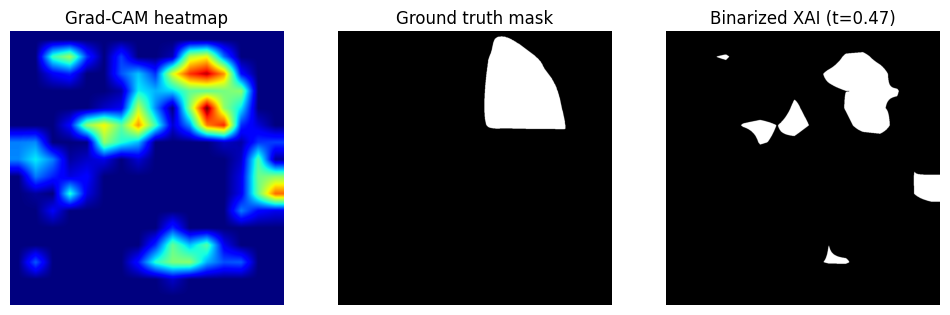

In [ ]:
import matplotlib.pyplot as plt

binary_heatmap = (heatmap_resized >= thresholds[best_idx]).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Grad-CAM heatmap')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap='gray')
plt.title('Ground truth mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_heatmap, cmap='gray')
plt.title(f'Binarized XAI (t={thresholds[best_idx]:.2f})')
plt.axis('off')
plt.show()

### Grad-CAM++

(-0.5, 511.5, 511.5, -0.5)

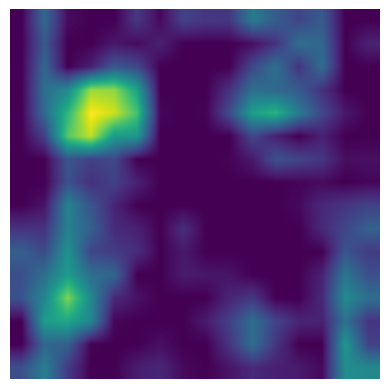

In [ ]:
cam = GradCAMPlusPlus(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

plt.imshow(heatmap[0])
plt.axis('off')

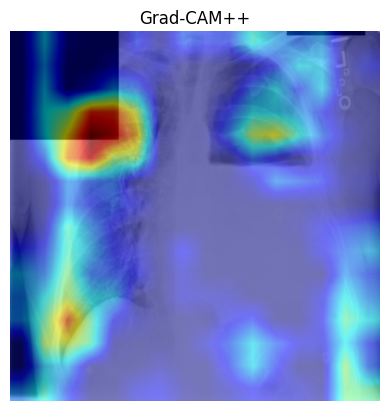

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM++")
plt.show()

### Score-CAM

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("Score-CAM")
plt.show()

### XGradCAM

(-0.5, 511.5, 511.5, -0.5)

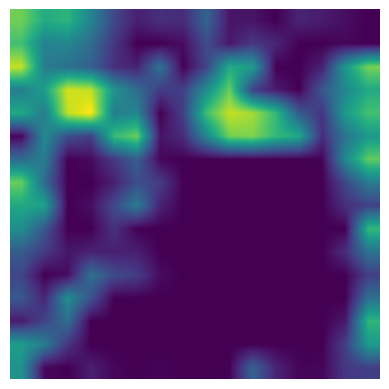

In [ ]:
cam = XGradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

plt.imshow(heatmap[0])
plt.axis('off')

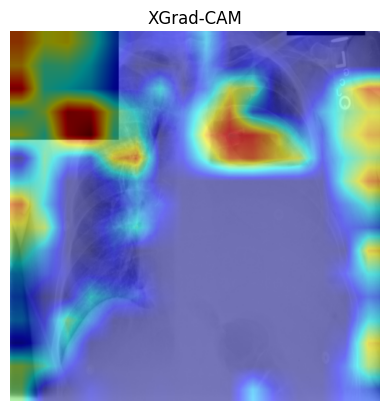

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("XGrad-CAM")
plt.show()

### EigenCAM

(-0.5, 511.5, 511.5, -0.5)

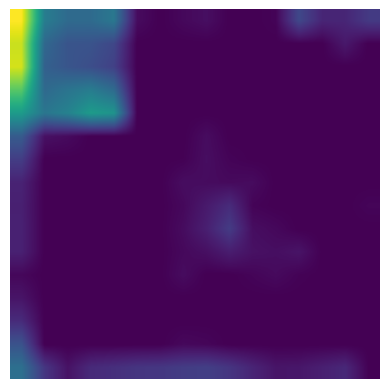

In [ ]:
cam = EigenCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

plt.imshow(heatmap[0])
plt.axis('off')

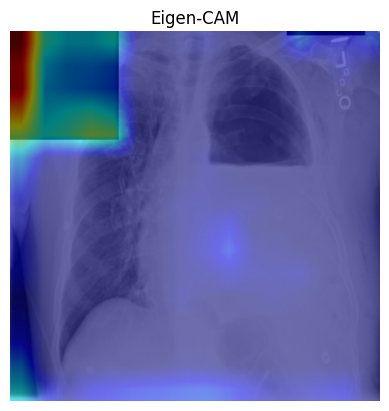

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("Eigen-CAM")
plt.show()

### FullGrad

(-0.5, 511.5, 511.5, -0.5)

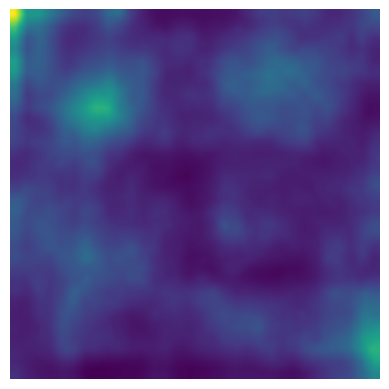

In [ ]:
cam = FullGrad(model=model, target_layers=layers)
heatmap = cam(input_tensor=input_tensor, targets=classes)

plt.imshow(heatmap[0])
plt.axis('off')

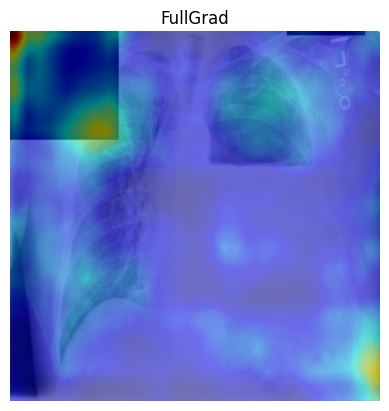

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Cargar imagen original
img = tensor_to_pil(input_tensor)

# 2. Convertir a array normalizado entre 0 y 1 (float32)
rgb_img = np.array(img).astype(np.float32) / 255.0

# 3. Superponer mapa de calor usando utilidad de Grad-CAM
cam_image = show_cam_on_image(rgb_img, heatmap[0], use_rgb=True)

# 4. Graficar
plt.imshow(cam_image)
plt.axis('off')
plt.title("FullGrad")
plt.show()

Aprovecha todas las capas de la red